学习率是深度学习训练中至关重要的参数，很多时候一个合适的学习率才能发挥出模型的较大潜力。

In [76]:
import torch
from torch.optim import SGD
from torch.optim import lr_scheduler
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt

model = [Parameter(torch.randn(2, 2, requires_grad=True))]

In [120]:
def generate_xy(_optimizer, _scheduler):
    x, y = [],[]
    epoch = 0
    _optimizer.zero_grad()
    for epoch in range(0,23):
        _optimizer.step()
        x.append(epoch)
        y.append(_optimizer.param_groups[0]['lr'])
        _scheduler.step()
        pass
    x.append(epoch+1)
    y.append(_optimizer.param_groups[0]['lr'])
    return x, y

def plot_xy(x,y):
    plt.plot(x,y)
    plt.show()
    # from pprint import pprint
    # pprint(x, compact=True)
    # pprint(y, compact=True)

# 01.StepLR
这是最简单常用的学习率调整方法，每过step_size轮，将此前的学习率乘以gamma。

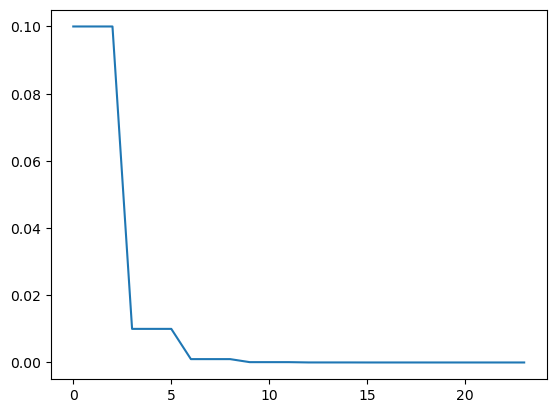

In [122]:
optimizer = SGD(model, lr=0.1)
scheduler=lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
plot_xy(*generate_xy(optimizer,scheduler))

# 02.MultiStepLR
MultiStepLR同样也是一个非常常见的学习率调整策略，它会在每个milestone时，将此前学习率乘以gamma。

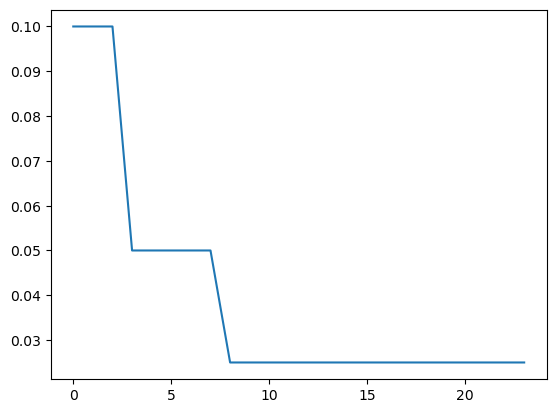

In [79]:
optimizer = SGD(model, lr=0.1)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[3,8], gamma=0.5)
plot_xy(*generate_xy(optimizer,scheduler))

# 03.ExponentialLR
ExponentialLR是指数型下降的学习率调节器，每一轮会将学习率乘以gamma，所以这里千万注意gamma不要设置的太小，不然几轮之后学习率就会降到0。

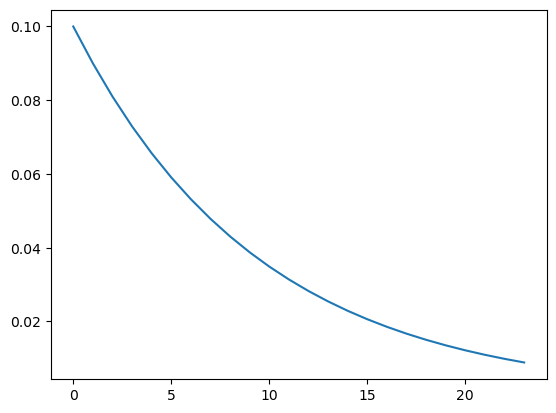

In [80]:
optimizer = SGD(model, lr=0.1)
scheduler=lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
plot_xy(*generate_xy(optimizer,scheduler))

# 04.LinearLR
LinearLR是线性学习率，给定起始factor和最终的factor，LinearLR会在中间阶段做线性插值，比如学习率为0.1，起始factor为1，最终的factor为0.1，那么第0次迭代，学习率将为0.1，最终轮学习率为0.01。下面设置的总轮数total_iters为80,所以超过80时，学习率恒为0.01。

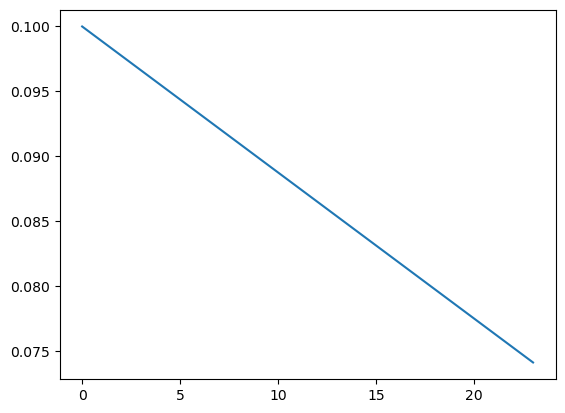

In [81]:
optimizer = SGD(model, lr=0.1)
scheduler=lr_scheduler.LinearLR(optimizer,start_factor=1,end_factor=0.1,total_iters=80)
plot_xy(*generate_xy(optimizer,scheduler))

# 05.CyclicLR
CyclicLR的参数要更多一些，它的曲线看起来就像是不断的上坡与下坡，base_lr为谷底的学习率，max_lr为顶峰的学习率，step_size_up是从谷底到顶峰需要的轮数，step_size_down时从顶峰到谷底的轮数。至于为啥这样设置，可以参见论文,简单来说最佳学习率会在base_lr和max_lr，CyclicLR不是一味衰减而是出现增大的过程是为了避免陷入鞍点。

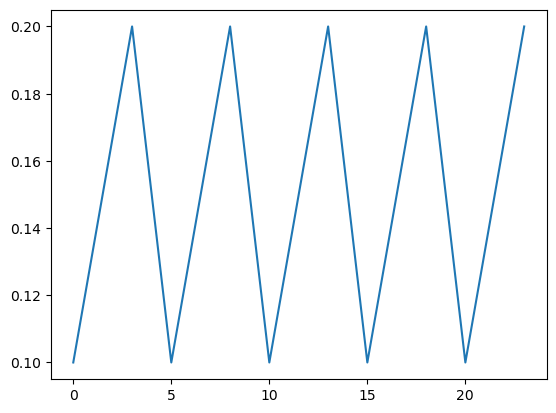

In [82]:
optimizer = SGD(model, lr=0.1)
scheduler=lr_scheduler.CyclicLR(optimizer,base_lr=0.1,max_lr=0.2,step_size_up=3,step_size_down=2)
plot_xy(*generate_xy(optimizer,scheduler))

# 06.OneCycleLR
OneCycleLR顾名思义就像是CyclicLR的一周期版本，它也有多个参数，max_lr就是最大学习率，pct_start是学习率上升部分所占比例，初始学习率initial_lr=max_lr/div_factor,最小的学习率min_lr=initial_lr/final_div_factor，总的迭代次数为total_steps。
[Docs > torch.optim > OneCycleLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html?highlight=onecyclelr#torch.optim.lr_scheduler.OneCycleLR)

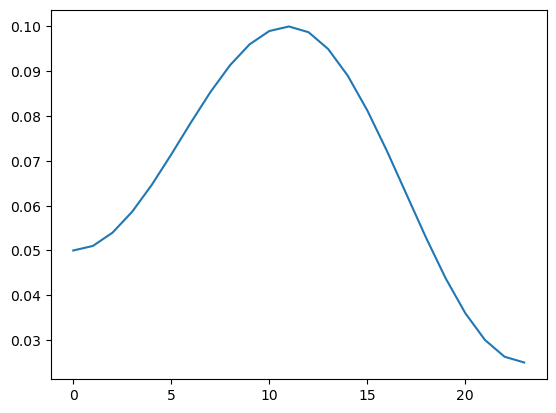

In [86]:
optimizer = SGD(model, lr=0.1)
scheduler=lr_scheduler.OneCycleLR(optimizer,max_lr=0.1,pct_start=0.5,total_steps=24,div_factor=2,final_div_factor=2)
plot_xy(*generate_xy(optimizer,scheduler))

# 07.CosineAnnealingLR
CosineAnnealingLR是余弦退火学习率，T_max是周期的一半，最大学习率在optimizer中指定，最小学习率为eta_min。这里同样能够帮助逃离鞍点。值得注意的是最大学习率不宜太大，否则loss可能出现和学习率相似周期的上下剧烈波动。

$$
\eta_t=\eta_\min + \frac12(\eta_\max-\eta_\min)(1+\cos(\frac{T_{cur}}{T_\max}\pi))
$$

其中，$\eta_\min$ 和 $\eta_\max$ 为最小和最大学习率；$T_{cur}$ 为上次重启后的 epoch 计数；$T_\max$ 为经过多少个 epoch 重启

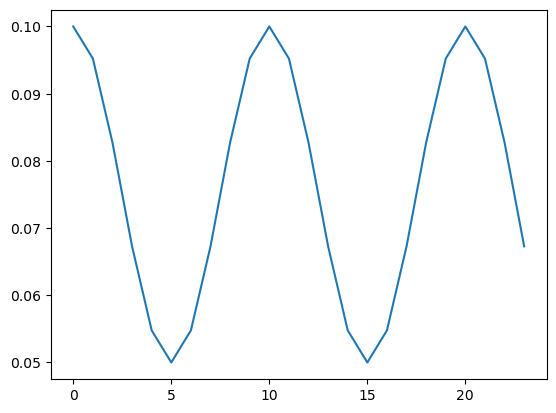

In [88]:
optimizer = SGD(model, lr=0.1)
scheduler=lr_scheduler.CosineAnnealingLR(optimizer,T_max=5,eta_min=0.05)
plot_xy(*generate_xy(optimizer,scheduler))

# 08.CosineAnnealingWarmRestarts

CosineAnnealingWarmRestarts是有预热的余弦退火学习率，T_0为第一个周期，学习率下降到 eta_min 后，新的周期数=前一周期数*T_mult。

$$
\eta_t=\eta_\min+\frac12(\eta_\max-\eta_\min)(1+\cos(\frac{T_{cur}}{T_i}\pi))
$$

使用 $T_i$ 代替了 $T_\max$，使得每次重启后的 周期会变

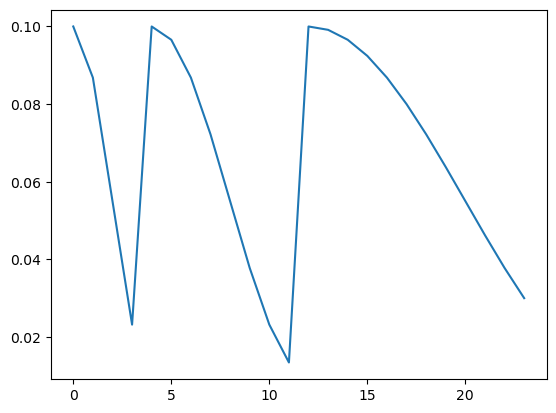

In [90]:
optimizer = SGD(model, lr=0.1)
scheduler=lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=4, T_mult=2, eta_min=0.01)
plot_xy(*generate_xy(optimizer,scheduler))

# 09.LambdaLR
LambdaLR其实没有固定的学习率曲线，名字中的lambda指的是可以将学习率自定义为一个有关epoch的lambda函数，比如下面我们定义了一个指数函数，实现了ExponentialLR的功能。

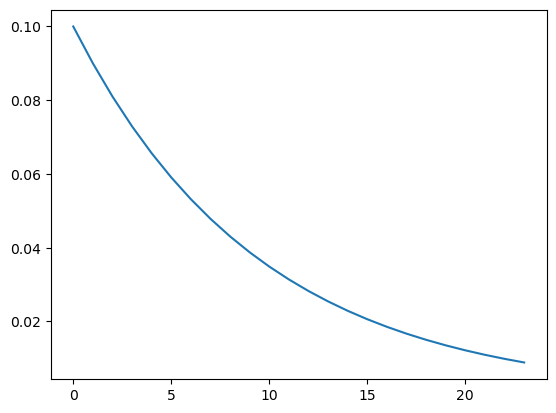

In [91]:
optimizer = SGD(model, lr=0.1)
scheduler=lr_scheduler.LambdaLR(optimizer,lr_lambda=lambda epoch:0.9**epoch)
plot_xy(*generate_xy(optimizer,scheduler))

# 10.SequentialLR
SequentialLR可以将多个学习率调整策略按照顺序串联起来,在milestone时切换到下一个学习率调整策略。下面就是将一个指数衰减的学习率和线性衰减的学习率结合起来。

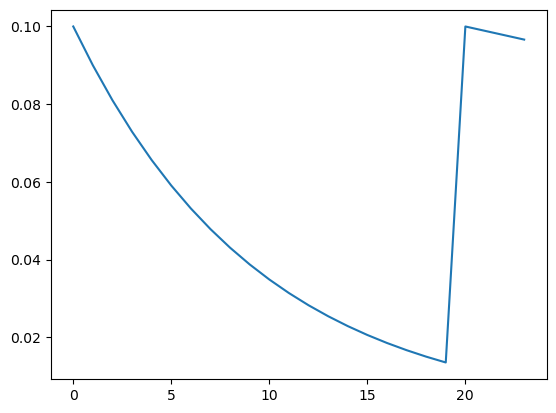

In [101]:
optimizer = SGD(model, lr=0.1)
scheduler=lr_scheduler.SequentialLR(optimizer,schedulers=[
        lr_scheduler.ExponentialLR(optimizer, gamma=0.9),
        lr_scheduler.LinearLR(optimizer,start_factor=1,end_factor=0.1,total_iters=80)
        ],milestones=[20])
plot_xy(*generate_xy(optimizer,scheduler))

# 11.ChainedScheduler
ChainedScheduler和SequentialLR类似，也是按照顺序调用多个串联起来的学习率调整策略，不同的是ChainedScheduler里面的学习率变化是连续的。

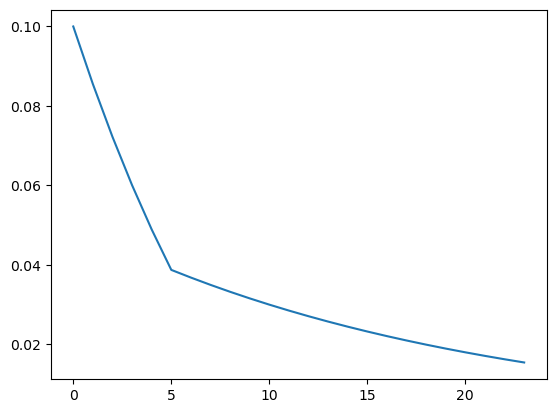

In [102]:
optimizer = SGD(model, lr=0.1)
scheduler=lr_scheduler.ChainedScheduler(
        [
                lr_scheduler.LinearLR(optimizer,start_factor=1,end_factor=0.5,total_iters=5),
                lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
        ])
plot_xy(*generate_xy(optimizer,scheduler))

# 12.ConstantLR
ConstantLRConstantLR非常简单，在total_iters轮内将optimizer里面指定的学习率乘以factor,total_iters轮外恢复原学习率。

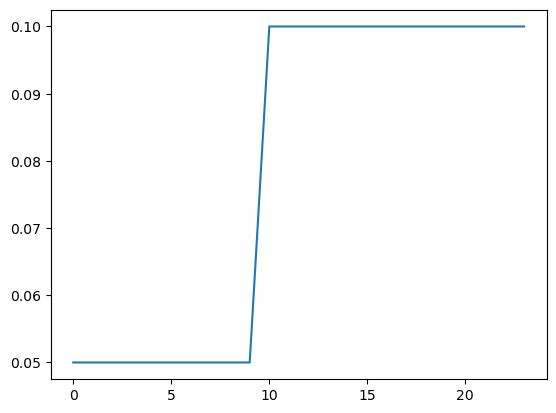

In [105]:
optimizer = SGD(model, lr=0.1)
scheduler=lr_scheduler.ConstantLR(optimizer,factor=0.5,total_iters=10)
plot_xy(*generate_xy(optimizer,scheduler))

# 13.ReduceLROnPlateau
ReduceLROnPlateau参数非常多，其功能是自适应调节学习率，它在step的时候会观察验证集上的loss或者准确率情况，loss当然是越低越好，准确率则是越高越好，所以使用loss作为step的参数时，mode为min，使用准确率作为参数时，mode为max。factor是每次学习率下降的比例，新的学习率等于老的学习率乘以factor。patience是能够容忍的次数，当patience次后，网络性能仍未提升，则会降低学习率。threshold是测量最佳值的阈值，一般只关注相对大的性能提升。min_lr是最小学习率，eps指最小的学习率变化，当新旧学习率差别小于eps时，维持学习率不变。

In [123]:
optimizer = SGD(model, lr=0.1)
scheduler=lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.5,patience=5,threshold=1e-4,threshold_mode='abs',cooldown=0,min_lr=0.001,eps=1e-8)
# plot_xy(*generate_xy(optimizer,scheduler))

# 14.CosineWarmupScheduler

CosineWarmupScheduler 是自定义的计划，是带预热的COS学习率调整策略

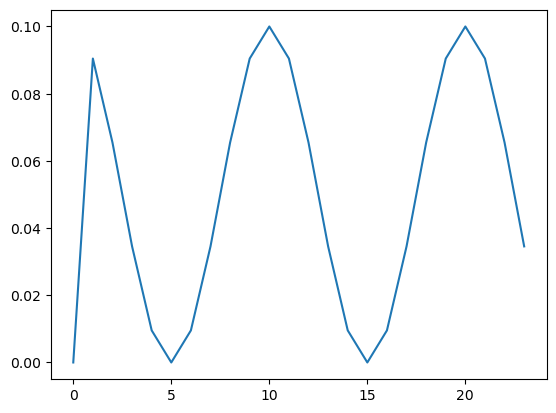

In [127]:
import numpy as np
class CosineWarmupScheduler(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizers, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizers)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

optimizer = SGD(model, lr=0.1)
scheduler=CosineWarmupScheduler(optimizer,warmup=True,max_iters=5)
plot_xy(*generate_xy(optimizer,scheduler))

# Warmup
初始训练阶段，直接使用较大学习率会导致权重变化较大，出现振荡现象，使得模型不稳定，加大训练难度。而使用Warmup预热学习率，在开始的几个epoch，逐步增大学习率，如下图所示，使得模型逐渐趋于稳定，等模型相对稳定后再选择预先设置的基础学习率进行训练，使得模型收敛速度变得更快，模型效果更佳